In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from summit.utils.dataset import DataSet
from summit.strategies.random import lhs
from summit.strategies import TSEMO
from summit.benchmarks import DTLZ2

import GPy
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hiplot as hip

Load data from unit test of TSEMO.

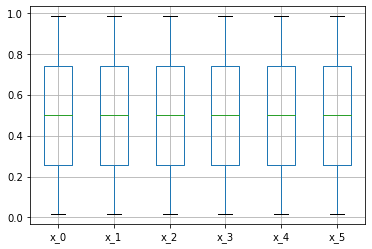

In [41]:
tsemo = TSEMO.load('data/tsemo_settings.json')
data = tsemo.all_experiments
data.iloc[0:30].boxplot(column=[f'x_{i}'for i in range(6)])

In [23]:
n_training = 30
input_columns = [v.name for v in tsemo.domain.input_variables]
output_columns = ['y_0', 'y_1']
# Scale decision variables between 0 and 1
# inputs = data[data['strategy']=='LHS'][input_columns]
inputs = data[input_columns].iloc[0:n_training]
input_min = inputs.min()
input_max = inputs.max()
scaled_inputs = (inputs-input_min)/(input_max-input_min)

# Scale objectives to 0 mean and unit variance
# outputs = data[data['strategy']=='LHS'][output_columns]
outputs = data[output_columns][0:n_training]
output_mean = outputs.mean()
output_std = outputs.std()
scaled_outputs = (outputs-output_mean)/output_std

# Join back
scaled_data = pd.concat([scaled_inputs, scaled_outputs], axis=1)
scaled_data.head(5)

,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0.379310,0.517241,0.724138,0.551724,0.206897,0.344828,0.120861,-0.548730
1,0.310345,1.000000,0.448276,0.655172,0.965517,0.655172,0.907604,-0.429278
2,0.655172,0.931034,0.586207,0.758621,0.655172,0.793103,-0.427187,0.523125
3,0.586207,0.172414,0.137931,0.137931,0.724138,0.068966,0.128447,0.728401
4,0.275862,0.896552,0.482759,0.241379,0.689655,0.000000,0.972597,-0.585437


## Hyperparameter Screening

In [43]:
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
m = GPy.models.GPRegression(scaled_inputs.to_numpy(), 
                            scaled_outputs[['y_0']].to_numpy(), 
                            kern, noise_var=1e-3)
m.kern.lengthscale.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3),warning=False)
m.kern.lengthscale.set_prior(GPy.priors.LogGaussian(0, 10), warning=False)
m.kern.variance.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3), warning=False)
m.kern.variance.set_prior(GPy.priors.LogGaussian(-6, 10), warning=False)
m.Gaussian_noise.constrain_bounded(np.exp(-6), 1, warning=False)
m

GP_regression.,value,constraints,priors
Exponential.variance,1.0,+ve,"lnN(-6, 10)"
Exponential.lengthscale,"(6,)",+ve,"lnN(0, 10)"
Gaussian_noise.variance,0.5012393760883331,"0.0024787521766663585,1.0",


In [44]:
# Try changing kernel lengthscales
m.kern.lengthscale = 2*np.ones(6)
print("Lengthscales=2:", m.objective_function())

m.kern.lengthscale = 0.2*np.ones(6)
print("Lengthscales=0.2:", m.objective_function())

Lengthscales=2: 65.34693075007348
Lengthscales=0.2: 66.56979109297606


* Parameters to screen:
    * Variance
    * Lengthscales (x6)
    * Gaussian noise


In [46]:
screening_values = lhs(8, int(1e5))
scaling_variance_log=[np.log(np.sqrt(1e-3)), np.log(np.sqrt(1e3))]
scaling_lengthscales_log=[np.log(np.sqrt(1e-3)), np.log(np.sqrt(1e3))]
scaling_noise_log=[-6, 0]

records = []

for values in screening_values:
    variance = values[0]*(scaling_variance_log[1]-scaling_variance_log[0])+scaling_variance_log[0]
    lengthscales = values[1:7]*(scaling_lengthscales_log[1]-scaling_lengthscales_log[0])+scaling_lengthscales_log[0]
    noise = values[7]*(scaling_noise_log[1]-scaling_noise_log[0])+scaling_noise_log[0]
    m.kern.variance = np.exp(variance)
    m.kern.lengthscale  = np.exp(lengthscales)
    m.Gaussian_noise.variance = np.exp(noise)
    record = {f'log_x_{i}': lengthscale for i, lengthscale in enumerate(lengthscales)}
    record.update({'log_variance': variance,'log_noise': noise,
                   'objective_function': m.objective_function()})
    records.append(record)
    
df = pd.DataFrame(records)

In [50]:
records_top = df[df['objective_function']<60].to_dict(orient='records')
exp = hip.Experiment.from_iterable(records_top)
exp.display_data(hip.Displays.PARALLEL_PLOT).update({'hide': ['uid']})
exp.display()

<IPython.core.display.Javascript object>

This shows us that the hyperparameter optimisation landscape is rough with lots of local minima. We need a global optimisation algorithm to solve it.

##  Optimizer

In [ ]:
#First the L-BFSG optimizer
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
m_bfsg = GPy.models.GPRegression(scaled_inputs.to_numpy(), 
                                   scaled_outputs[['y_0']].to_numpy(), 
                                   kern, noise_var=1e-3)
m_bfsg.kern.lengthscale.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3),warning=False)
m_bfsg.kern.lengthscale.set_prior(GPy.priors.LogGaussian(0, 10), warning=False)
m_bfsg.kern.variance.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3), warning=False)
m_bfsg.kern.variance.set_prior(GPy.priors.LogGaussian(-6, 10), warning=False)
m_bfsg.Gaussian_noise.constrain_bounded(np.exp(-6), 1, warning=False)
m_bfsg.optimize_restarts(50)
m_bfsg

In [31]:
m_bfsg.kern.lengthscale

index,GP_regression.Exponential.lengthscale,constraints,priors
[0],0.63120971,+ve,"lnN(0, 10)"
[1],12.91846886,+ve,"lnN(0, 10)"
[2],3.72668338,+ve,"lnN(0, 10)"
[3],10.65249153,+ve,"lnN(0, 10)"
[4],4.88584008,+ve,"lnN(0, 10)"
[5],5.50278530,+ve,"lnN(0, 10)"


In [36]:
test_data = data.iloc[n_training:]
scaled_test = (test_data[input_columns]-input_min)/(input_max-input_min)
y_pred_scaled, y_pred_var_scaled = m_bfsg.predict(scaled_test.to_numpy())

y_pred = y_pred_scaled[:,0]*output_std['y_0'].to_numpy()[0] + output_mean['y_0'].to_numpy()[0]
y_pred_var = y_pred_var_scaled*output_std['y_0'].to_numpy()[0]
y_real = test_data['y_0'].to_numpy()
square_error = (y_pred-y_real)**2
rmse = np.sqrt(np.mean(square_error))
print("Number of training data:", scaled_inputs.shape[0])
print("Root mean square error:",rmse)

Number of training data: 30
Root mean square error: 0.08240710754966049


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


Text(0.5, 1.0, 'Parity Plot')

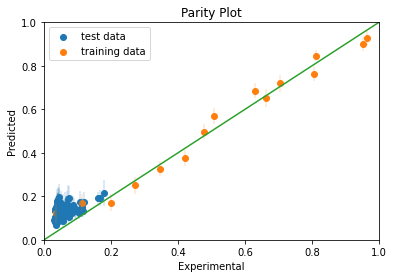

In [39]:
# Plot test data
plt.scatter(y_real, y_pred, label="test data")
plt.errorbar(y_real, y_pred, yerr=y_pred_var, fmt='none', alpha=0.2)

# Plot training data
y_pred_train_scaled , y_pred_var_train_scaled = m_bfsg.predict(scaled_inputs.to_numpy())
y_pred_train = y_pred_train_scaled[:,0]*output_std['y_0'].to_numpy()[0] + output_mean['y_0'].to_numpy()[0]
y_pred_var_train = y_pred_var_train_scaled*output_std['y_0'].to_numpy()[0]
plt.scatter(outputs['y_0'].to_numpy(), y_pred_train, label="training data")
plt.errorbar(outputs['y_0'].to_numpy(), y_pred_train, 
             yerr=y_pred_var_train, fmt='none', alpha=0.2)

plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.legend()
plt.title('Parity Plot')

In [15]:
class BasinHopping(GPy.inference.optimization.Optimizer):
    
    def __init__(self, T=1.0, **kwargs):
        super().__init__(**kwargs)
        self.opt_name = 'BasinHopping'
        self.T = T
        
    def opt(self, x_init, f_fp=None, f=None, fp=None):
        minimizer_kwargs = {"jac": True}
        res = scipy.optimize.basinhopping(f_fp, x_init, niter=self.max_iters, 
                                          minimizer_kwargs=minimizer_kwargs,
                                          T=self.T)
        self.f_opt = res.fun
        self.x_opt = res.x
        self.status = 'maximum number of function evaluations exceeded'

In [17]:
#Optimize using basin hopping
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
m = GPy.models.GPRegression(scaled_inputs.to_numpy(), 
                            scaled_outputs[['y_0']].to_numpy(),
                            kern, 
                            noise_var=1e-3)
m.kern.lengthscale.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3),warning=False)
m.kern.lengthscale.set_prior(GPy.priors.LogGaussian(0, 10), warning=False)
m.kern.variance.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3), warning=False)
m.kern.variance.set_prior(GPy.priors.LogGaussian(-6, 10), warning=False)
m.Gaussian_noise.constrain_bounded(np.exp(-6), 1, warning=False)
m.optimize(optimizer=BasinHopping(max_iters=100, T=0.1))
m

GP_regression.,value,constraints,priors
Exponential.variance,0.34903905258526485,+ve,"lnN(-6, 10)"
Exponential.lengthscale,"(6,)",+ve,"lnN(0, 10)"
Gaussian_noise.variance,0.0024787522228870013,"0.0024787521766663585,1.0",


In [18]:
test_data = data.iloc[n_training:]
scaled_test = (test_data[input_columns]-input_min)/(input_max-input_min)
y_pred_scaled, y_pred_var_scaled = m.predict(scaled_test.to_numpy())

y_pred = y_pred_scaled[:,0]*output_std['y_0'].to_numpy()[0] + output_mean['y_0'].to_numpy()[0]
y_pred_var = y_pred_var_scaled*output_std['y_0'].to_numpy()[0]
y_real = test_data['y_0'].to_numpy()
square_error = (y_pred-y_real)**2
rmse = np.sqrt(np.mean(square_error))
print("Number of training data:", n_training)
print("Number of test data:", data.shape[0]-n_training)
print("Root mean square error:",rmse)

Number of training data: 35
Number of test data: 94
Root mean square error: 0.07693647033147985


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


Text(0.5, 1.0, 'Parity Plot')

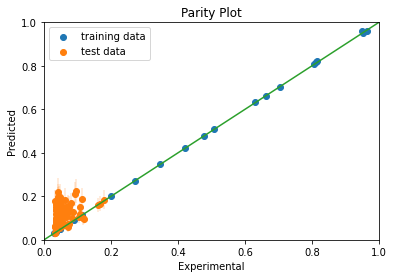

In [19]:
# Plot test data
plt.scatter(y_real, y_pred, label='test data')
plt.errorbar(y_real, y_pred, yerr=y_pred_var, fmt='none', alpha=0.2)

# Plot training data
y_pred_train_scaled , y_pred_var_train_scaled = m.predict(scaled_inputs.to_numpy())
y_pred_train = y_pred_train_scaled[:,0]*output_std['y_0'].to_numpy()[0] + output_mean['y_0'].to_numpy()[0]
y_pred_var_train = y_pred_var_train_scaled*output_std['y_0'].to_numpy()[0]
plt.scatter(outputs['y_0'].to_numpy(), y_pred_train, label="training data")
plt.errorbar(outputs['y_0'].to_numpy(), y_pred_train, 
             yerr=y_pred_var_train, fmt='none', alpha=0.2)

plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Parity Plot')

Because all teh training data is centered in one place, it is not able to train a good model.

In [112]:
m.predict(0.5*np.ones([1,6]))

(array([[0.19653369]]), array([[0.04380293]]))

In [115]:
dtlz2 = DTLZ2()
conditions = DataSet(0.5*np.ones([1,6]), columns=[f'x_{i}' for i in range(6)])
dtlz2.run_experiments(conditions)

,computation_t,experiment_t,strategy,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0,0.0193219,NaN,0.5,0.5,0.5,0.5,0.5,0.5,0.707107,0.707107


## Train on Matlab Initial Data

In [52]:
# Read in data from one Matlab experiment
X = pd.read_csv('data/matlab/experiment_20/X.csv', names=[f"x_{i}" for i in range(6)])
y = pd.read_csv('data/matlab/experiment_20/Y.csv', names=['y_0', 'y_1'])

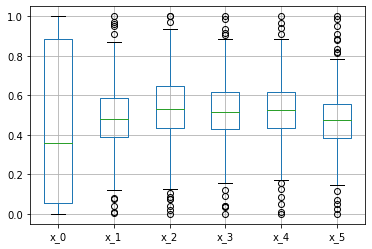

In [53]:
X.boxplot(column=[f'x_{i}' for i in range(6)])

In [54]:
# Train-test split
n_training_matlab = 30
X_train = X[:n_training_matlab]
X_test =  X[n_training_matlab:]
y_train = y[:n_training_matlab]
y_test = y[n_training_matlab:]

# Scale decision variables between 0 and 1
X_min = X_train.min()
X_max = X_train.max()
X_scaled = (X_train-X_min)/(X_max-X_min)

# Scale objectives to 0 mean and unit variance
y_mean = y_train.mean()
y_std = y_train.std()
y_scaled = (y_train-y_mean)/y_std

In [55]:
#First the L-BFSG optimizer
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
m_bfsg = GPy.models.GPRegression(X_scaled.to_numpy(), 
                                 y_scaled.to_numpy(), 
                                 kern, noise_var=1e-3)
m_bfsg.kern.lengthscale.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3),warning=False)
m_bfsg.kern.lengthscale.set_prior(GPy.priors.LogGaussian(0, 10), warning=False)
m_bfsg.kern.variance.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3), warning=False)
m_bfsg.kern.variance.set_prior(GPy.priors.LogGaussian(-6, 10), warning=False)
m_bfsg.Gaussian_noise.constrain_bounded(np.exp(-6), 1, warning=False)
m_bfsg.optimize_restarts(50, verbose=False)
m_bfsg

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/core/parameterization/priors.py:182: RuntimeWarning:overflow encountered in true_divide
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern

GP_regression.,value,constraints,priors
Exponential.variance,0.5838183988289956,+ve,"lnN(-6, 10)"
Exponential.lengthscale,"(6,)",+ve,"lnN(0, 10)"
Gaussian_noise.variance,0.00247875409818706,"0.0024787521766663585,1.0",


In [57]:
scaled_test = (X_test-X_min)/(X_max-X_min)
y_pred_scaled, y_pred_var_scaled = m_bfsg.predict(scaled_test.to_numpy())

y_pred = y_pred_scaled[:,0]*y_std['y_0'] +y_mean['y_0']
y_pred_var = y_pred_var_scaled*y_std['y_0']
square_error = (y_pred-y_test['y_0'])**2
rmse = np.sqrt(np.mean(square_error))
print("Number of training data:", n_training_matlab)
print("Number of test data:", X.shape[0]-n_training_matlab)
print("Test Root mean square error:",rmse)

Number of training data: 30
Number of test data: 100
Test Root mean square error: 0.2801738188795582


In [ ]:
square_error

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


Text(0.5, 1.0, 'Parity Plot')

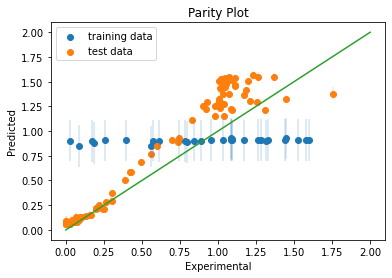

In [59]:
#Plot training data
y_pred_train_scaled , y_pred_var_train_scaled = m.predict(X_train.to_numpy())
y_pred_train = y_pred_train_scaled[:,0]*y_std['y_0']+y_mean['y_0']
y_pred_var_train = y_pred_var_train_scaled*y_std['y_0']
plt.scatter(y_train['y_0'], y_pred_train, label="training data")
plt.errorbar(y_train['y_0'], y_pred_train, 
             yerr=y_pred_var_train, fmt='none', alpha=0.2)


# Plot test data
plt.scatter(y_test['y_0'], y_pred, label='test data')
plt.errorbar(y_test['y_0'], y_pred, yerr=y_pred_var[:,0], fmt='none', alpha=0.2)
plt.plot([0,2],[0,2])
plt.legend()
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Parity Plot')